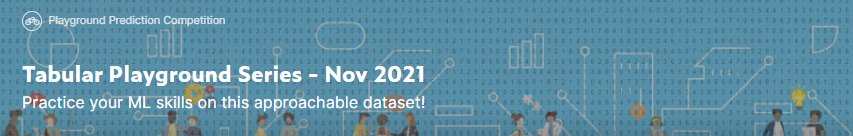

 **Reference thesis** : *TABNET: Attentive Interpretable Tabular Learning (2019)*

# Model architecture

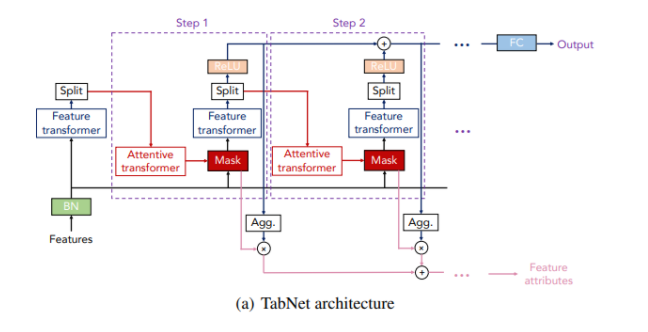

# ABSTRACT

The author says that TABNET is a high-performance interpretable deep learning structured data network.  
TabNet uses a sequential attention mechanism that smoothly selects a sensible shape at each decision-making  
step and then aggregates the processed information to make a final predictive decision.  
By explicitly selecting the sparse feature, TabNet learns very efficiently at each decision-making step to utilize  
the relevant variables that give high-performance model results to the fully relevant variables in the model capacity.

In [ ]:
#IMPORT THE LIBRARIES....
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns",None)

# Import Data

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-nov-2021/train.csv")

# EDA + Data processing

In [ ]:
train.isnull().sum()[train.isnull().sum() != 0]

In [ ]:
train_df = train.drop(['id', 'target'], axis = 1 )

In [ ]:
train_df.iloc[:, 0:,].describe()

In [ ]:
from tqdm import tqdm
features = train_df.columns.tolist()
len(features)


for col in tqdm(features):
    train_df[col+'_bin'] = train_df[col].apply(lambda x: 1 if np.cbrt(x)>0 else 0)
## The cube root of the variable x is 1 if it is greater than 0 and 0 if it is less than 0.


print(f"train_df: {train_df.shape}")
train_df.head(20)

In [ ]:
!pip install pytorch-tabnet

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:
train_y = train['target']

In [ ]:
train = pd.concat([train_df, train_y], axis =1)

In [ ]:
train_df.describe()

In [ ]:
target = 201    # 203번째 컬럼
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"] ,p =[.8, .2], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [ ]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

In [ ]:
# Contains dimension and idxs of categorical variable for categorical embedding.
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
test = pd.read_csv("../input/tabular-playground-series-nov-2021/test.csv")
test = test.drop(['id'], axis = 1)

Create a derived variable in the same way as train.

In [ ]:
from tqdm import tqdm
features = test.columns.tolist()
len(features)

for col in tqdm(features):
    test[col+'_bin'] = test[col].apply(lambda x: 1 if np.cbrt(x)>0 else 0)

print(f"test_df: {test.shape}")
test.head(20)

In [ ]:
if "Set" not in test.columns:
    test["Set"] = np.random.choice([ "test"] ,p =[1.0], size=(test.shape[0],))


test_indices = test[test.Set=="test"].index

In [ ]:
nunique = test.nunique()
types = test.dtypes

categorical_columns = []
categorical_dims =  {}
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

In [ ]:
# Contains dimension and idxs of categorical variable for categorical embedding.
unused_feat = ['Set']
features = [ col for col in test.columns if col not in unused_feat] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

**Split data**

In [ ]:
X_test = test[features].values[test_indices]

In [ ]:
X_train = train[features].values[train_indices]
y_train = train['target'].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train['target'].values[valid_indices]

X_test = test[features].values[test_indices]

# Modeling

In [ ]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

In [ ]:
max_epochs = 50

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

In [ ]:
prediction = clf.predict(X_test)

In [ ]:
test = pd.read_csv("../input/tabular-playground-series-nov-2021/test.csv")

In [ ]:
submission = pd.DataFrame({'Id':test['id'], 'target':prediction})
submission.to_csv("./submission.csv", index =False)
submission.head(15)